In [1]:
import os
import sys
import json
from scipy import stats
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, ShuffleSplit
from tqdm import tqdm
import warnings
import matplotlib as mpl
import plot_utils

warnings.filterwarnings('ignore', 'invalid value encountered in true_divide')

## Settings

In [2]:
TEXTWIDTH = 6.7261  # in
DPI = 360

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Colors

In [5]:
ot1_color = 'tab:green'
palette_tcrs = {'OT1': ot1_color, 
                'OTI': ot1_color, 
                'Educated': 'tab:orange',
                'Naive': 'tab:blue', 
                'Human': 'Firebrick'
               }
palette_naive_test = 'Blues'
palette_naive_ot1 = 'Greens'
color_random ='silver'
color_mice = 'silver'

## Helper functions

In [6]:
def assign_repertoire(tcr):
    if tcr == 'OTI_PH':
        return 'OTI'
    if tcr.startswith('ED'):
        return 'Educated'
    if tcr.startswith('R'):
        return 'Human'
    return 'Naive'

## Load Data

In [7]:
def load_tcr_dists(do_tumor=False):
    if do_tumor:
        dists = pd.read_excel('../results/TCRdists.xlsx', 'human', index_col=0)
    else:
        dists = pd.read_excel('../results/TCRdists.xlsx', 'murine', index_col=0)
        dists.index = dists.index.str.upper()
        dists.columns = dists.columns.str.upper()
        rename_dict = {'OT1': 'OTI_PH'}
        dists = dists.rename(columns=rename_dict, index=rename_dict)
    return dists
tcrdist_mice = load_tcr_dists()
tcrdist_human = load_tcr_dists(do_tumor=True)

In [8]:
def compute_classification_metrics(g):
    return pd.Series({
        'AUC': (
            metrics.roc_auc_score(g['is_activated'], g['pred'])
            if np.isfinite(g['pred']).all() and 0 < g['is_activated'].mean() < 1
            else np.nan
        ),
        'APS': (
            metrics.average_precision_score(g['is_activated'], g['pred'])
            if np.isfinite(g['pred']).all()
            else np.nan
        ),
    })

In [9]:
def compute_regression_metrics(g):
    return pd.Series({
        'MAE': g['abserr'].mean(),
        'R2': metrics.r2_score(g['activation'], g['pred']),
        'Pearson': g['activation'].corr(g['pred'], method='pearson'),
        'Spearman': g['activation'].corr(g['pred'], method='spearman'),
    })

In [10]:
def load_naive_test_data():
    fname = '../activation-prediction/results/cross-performance-educated-vs-naive.csv.gz'
    pdf = pd.read_csv(fname)
    pp = pdf.query('~is_educated').groupby(
        'tcr', as_index=False
    ).apply(compute_classification_metrics)
    return pp
naive_test_data = load_naive_test_data()

In [11]:
def load_classification_data():
    fname = f'../activation-prediction/results'
    pdf_mice = pd.read_csv(f'{fname}/SIINFEKL_tcr_stratified_classification_performance.csv.gz')
    pdf_human = pd.read_csv(f'{fname}/VPSVWRSSL_tcr_stratified_classification_performance.csv.gz')
    pdf = pd.concat([pdf_mice, pdf_human])
    
    pdf = pdf[pdf['normalization'].isin(['AS', 'pc'])]
    pdf = pdf[pdf['threshold'].isin([46.9, 66.09])]
    pdf = pdf[pdf['reduced_features']]
    
    pdf = pdf.query('mut_pos >= 0')
    pdf = pdf.groupby([
        'normalization', 'tcr'
    ]).filter(lambda g: 0 < g['is_activated'].sum() < len(g) - 1)

    pdf['Repertoire'] = pdf['tcr'].apply(assign_repertoire)

    df_metrics = pdf.groupby(['tcr'], as_index=False).apply(compute_classification_metrics).reset_index()

    df_metrics['Repertoire'] = df_metrics['tcr'].apply(assign_repertoire)
    return pdf, df_metrics
pdf_classification, df_classification_metrics = load_classification_data()

In [12]:
def load_regression_data():
    fname = f'../activation-prediction/results'
    pdf_mice = pd.read_csv(f'{fname}/SIINFEKL_tcr_stratified_regression_performance.csv.gz')
    pdf_mice = pdf_mice[~pdf_mice['tcr'].isin(['LR_OTI_1', 'LR_OTI_2'])]
    pdf_human = pd.read_csv(f'{fname}/VPSVWRSSL_tcr_stratified_regression_performance.csv.gz')
    pdf = pd.concat([pdf_mice, pdf_human])
    
    pdf = pdf[pdf['normalization'].isin(['AS', 'pc'])]
    pdf = pdf.query('mut_pos >= 0')
    pdf['Repertoire'] = pdf['tcr'].apply(assign_repertoire)

    pdf['abserr'] = pdf['err'].abs()
    df_metrics = pdf.groupby(['tcr'], as_index=False).apply(compute_regression_metrics).reset_index()

    df_metrics['Repertoire'] = df_metrics['tcr'].apply(assign_repertoire)
    return pdf, df_metrics
pdf_regression, df_regression_metrics = load_regression_data()

### Baseline Data

In [13]:
def load_ergo_data(db, suffix='', full=True):
    if full:
        df_normal = load_ergo_data(db, '', full=False)
        df_tumor = load_ergo_data(db, '_tumor', full=False)
        return pd.concat([df_normal, df_tumor])
    path_res = f'../baseline/results_pred/ergo_{db}{suffix}.csv'
    prediction_ergo = pd.read_csv(path_res, index_col=0)
    prediction_ergo = prediction_ergo[prediction_ergo['Peptide'] != 'SIINFEKL']
    return prediction_ergo

In [14]:
def load_imrex_data(suffix='', full=True):
    if full:
        df_normal = load_imrex_data('', full=False)
        df_tumor = load_imrex_data('_tumor', full=False)
        return pd.concat([df_normal, df_tumor])
    path_imrex = f'../baseline/results_pred/imrex{suffix}.csv'
    prediction_imrex = pd.read_csv(path_imrex, index_col=0)
    prediction_imrex = prediction_imrex[prediction_imrex['antigen.epitope'] != 'SIINFEKL']
    return prediction_imrex

In [15]:
def get_auc_per_tcr(data, tcr, y_true, col_pred):
    data_tmp = data[data['tcr'] == tcr]
    y_pred = data_tmp[col_pred]
    auc_score = metrics.roc_auc_score(y_true['is_activated'], y_pred)
    return auc_score

def get_spearman_per_tcr(data, tcr, y_true, col_pred):
    data_tmp = data[data['tcr'] == tcr].copy()
    data_tmp['activation_true'] = y_true['activation'].values
    auc_score = data_tmp['activation_true'].corr(data_tmp[col_pred], method='spearman')
    return auc_score

def load_baseline_data(metric='AUC'):
    prediction_ergo_vdjdb = load_ergo_data('vdjdb')
    prediction_ergo_mcpas = load_ergo_data('mcpas')
    prediction_imrex = load_imrex_data()

    prediction_ours = pdf_classification[pdf_classification['tcr'].isin(prediction_ergo_vdjdb['tcr'].unique())]
    
    metric_func = get_auc_per_tcr
    if metric == 'Spearman':
        metric_func = get_spearman_per_tcr
        predictin_outs = pdf_regression[pdf_regression['tcr'].isin(prediction_ergo_vdjdb['tcr'].unique())]
        
    performance = []    
    for tcr in prediction_ergo_vdjdb['tcr'].unique():
        if tcr in ['LR_OTI_1', 'LR_OTI_2']:
            continue
        y_true = prediction_ours[prediction_ours['tcr'] == tcr]#['is_activated']
        
        scores_ergo_mcpas = metric_func(prediction_ergo_mcpas, tcr, y_true, col_pred='Score')
        scores_ergo_vdjdb = metric_func(prediction_ergo_vdjdb, tcr, y_true, col_pred='Score')
        scores_imrex = metric_func(prediction_imrex, tcr, y_true, col_pred='prediction_score')
        scores_ours = metric_func(prediction_ours, tcr, y_true, col_pred='pred')
        performance.append([tcr, scores_ergo_mcpas, scores_ergo_vdjdb, scores_imrex, scores_ours])
    performance = pd.DataFrame(performance, columns=['tcr', 'ergo-mcpas', 'ergo-vdjdb', 'imrex', 'MAPLE'])

    performance = performance[~performance['tcr'].isin(['LR_OTI_1', 'LR_OTI_2'])]
    performance = performance.set_index('tcr')
    order = list(performance.index)
    order.remove('OTI_PH')
    order = ['OTI_PH'] + order
    performance = performance.reindex(order)
    return performance

performance_baseline = load_baseline_data()
performance_baseline_regression = load_baseline_data('Spearman')

## Statistical testing

In [16]:
def pval_2_asterix(val):
    if val < 0.0001:
        return '****'
    if val < 0.001:
        return '***'
    if val < 0.01:
        return '**'
    if val < 0.05:
        return '*'
    return ''

In [17]:
p_values_baseline = {}
for col in ['ergo-mcpas', 'ergo-vdjdb', 'imrex']:
    res = stats.ttest_rel(performance_baseline[col], performance_baseline['MAPLE'])
    p_values_baseline[col] = (res[1], pval_2_asterix(res[1]))
p_values_baseline

{'ergo-mcpas': (1.9316965637481774e-07, '****'),
 'ergo-vdjdb': (8.629125653356991e-07, '****'),
 'imrex': (1.0793929771092463e-06, '****')}

## Plotting Functions

In [18]:
def plot_auc(data, ax, ylabel=None, xlabel=None, metric_func=metrics.roc_curve, metric_name='AUC'):
    if metric_func == metrics.roc_curve:
        ax.plot([0, 1], [0, 1], c=color_random, linestyle='--')
    
    groups = data.groupby('tcr')
    for i, (tcr, g) in enumerate(groups):
        x, y, _ = metric_func(g['is_activated'], g['pred'])
        kwargs = {
            'c': palette_tcrs[g['Repertoire'].values[0]],
            'alpha': 0.3 if tcr != 'OTI_PH' else 1.0,
            'label': 'OTI_PH' if tcr == 'OTI_PH' else 'Educated' if 'ED' in tcr else 'Naive',
            'linewidth': 0.5
        }
        if metric_func == metrics.roc_curve:
            ax.plot(x, y, **kwargs)
        else:
            ax.plot(y, x, **kwargs)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(False)
    if ylabel:
        ax.set_ylabel(ylabel)
    else:
        ax.set_yticklabels([])
    if xlabel:
        ax.set_xlabel(xlabel)
    else:
        ax.set_xticklabels([])

    df_mean = df_classification_metrics[df_classification_metrics['tcr'].isin(data['tcr'])]
    mean = df_mean[metric_name].mean()
    ax.set_title(f'Avg {metric_name}: {mean:.3f}', pad=-2, size='small')
    sb.despine(ax=ax)

In [19]:
def tcr_dist_vs_metric(ax, aggr='min', metric='AUC'):
    if metric in df_classification_metrics.columns:
        scores_mice = df_classification_metrics[df_classification_metrics['Repertoire']!='Human']
        scores_human = df_classification_metrics[df_classification_metrics['Repertoire']=='Human']
    else:
        scores_mice = df_regression_metrics[df_regression_metrics['Repertoire']!='Human']
        scores_human = df_regression_metrics[df_regression_metrics['Repertoire']=='Human']

    distance_total = []
    values_total = []
    for i, (vals, dists, name) in enumerate([[scores_mice, tcrdist_mice, 'Mice'], [scores_human, tcrdist_human, 'Human']]):
        vals = vals.copy()
        dists = dists.reindex(vals['tcr']) 
        if aggr == 'min':
            dists = dists[dists!=0].min(axis=1).values
        else:
            dists = dists[dists!=0].mean(axis=1).values
        vals['TCRdist'] = dists
        vals['Repertoire'] = vals['tcr'].apply(assign_repertoire)
        sb.scatterplot(data=vals, x=metric, y='TCRdist', ax=ax, hue='Repertoire', palette=palette_tcrs, size=2.5)
        values_total += vals[metric].values.tolist()
        distance_total += vals['TCRdist'].values.tolist()
    
    sb.regplot(x=values_total, y=distance_total, ax=ax, scatter=False, color=color_mice,
               line_kws={'linewidth':1})
    
    test = stats.spearmanr(values_total, distance_total)
    print(f'{metric} correlation to tcrdist: {test}')
    ax.set_title(f'corr: {test[0]:.3f}     p-value: {test[1]:.3f}', pad=-2, size='small')
    
    ax.set_xlabel(metric)
    ax.set_xlim(0.2, 1.0)
    ax.legend().remove()
    ax.grid(False)
    sb.despine(ax=ax)

In [20]:
def plot_naive_test(ax, metric='AUC'):
    dd = pd.merge(naive_test_data, df_classification_metrics, left_on='tcr', right_on='tcr')
    dd = dd.rename(columns={f'{metric}_x': 'Leave-naive-out',
                            f'{metric}_y': 'Leave-TCR-out',
                            'tcr': 'TCR',}
                   ).melt('TCR', ['Leave-naive-out', 'Leave-TCR-out'],
                          var_name='Validation', value_name=metric
                         ).replace({'TCR': {'OTI_PH': 'OTI'}}
                                  ).sort_values(metric, ascending=False)
    sb.barplot(data=dd, x='TCR', y=metric, hue='Validation',
               palette=palette_naive_test, ax=ax, alpha=0.5)

    # re-draw OTI bars in green
    g0, g1, g2, g3 = sb.color_palette(palette_naive_ot1)[:4]
    ax.bar([1.8], dd.query('TCR=="OTI" & Validation == "Leave-naive-out"')[metric].values,
        width=0.38, color=g1, edgecolor=g0, linewidth=0.4)
    ax.bar([2.2], dd.query('TCR=="OTI" & Validation == "Leave-TCR-out"')[metric].values,
        width=0.38, color=g3, edgecolor=g1, linewidth=0.4)

    ax.legend(title='Validation Strategy')
    ax.grid(False)
    sb.despine(ax=ax)

In [21]:
def plot_metric_boxplot(metrics, ax):   
    bp_data = df_classification_metrics[['tcr', 'Repertoire'] + metrics].copy()
    bp_data = bp_data.melt(['tcr', 'Repertoire'], value_name='Value', var_name='Metric')
    sb.boxplot(
        data=bp_data,
        y='Value', hue='Repertoire', ax=ax, fliersize=1,
        x='Metric', hue_order=['OTI', 'Educated', 'Naive', 'Human'], palette=palette_tcrs,
        #color='#ffffffff'
    )
    
    ax.set_ylabel('')
    ax.legend().remove()
    ax.grid(False)
    sb.despine(ax=ax)

In [22]:
def tcr_to_color(tcr):
    if tcr.startswith('ED'):
        return palette_tcrs['Educated']
    elif tcr.startswith('R'):
        return palette_tcrs['Human']
    elif tcr == 'OTI_PH':
        return palette_tcrs['OT1']
    return palette_tcrs['Naive']

In [23]:
order = ['imrex', 'ergo-vdjdb', 'ergo-mcpas', 'MAPLE']
def plot_baseline_data(data, ax, metric='AUC'):
    data['tcr'] = data.index
    data = data.melt(['tcr'], value_name=metric, var_name='Model')
    data['color'] = [tcr_to_color(tcr) for tcr in data['tcr']]

    plot_base = sb.swarmplot(data=data, x='Model', y=metric, hue='tcr', size=2.5,
                           order=order,
                           palette=data['color'], ax=ax)
    plot_base.set(ylabel=metric)
    plot_base.set_xticklabels(['ImRex', 'ERGO2\nVDJdb', 'ERGO2\nMcPAS', 'MAPLE'])
    [label.set_fontweight('bold') for label in ax.get_xticklabels() if label.get_text()=='MAPLE']
    
    ax.get_legend().remove()
    plot_base.set(xlabel=None)
    sb.despine(ax=ax)
    ax.grid(False)    

In [24]:
def plot_legend(fig, offset=0):
    fig.legend([
            mpl.lines.Line2D([], [], c=palette_tcrs['OT1']),
            mpl.lines.Line2D([], [], c=palette_tcrs['Educated']),
            mpl.lines.Line2D([], [], c=palette_tcrs['Naive']),
            mpl.lines.Line2D([], [], c=palette_tcrs['Human']),
        ], ['OT1', 'Educated', 'Naive', 'Human'], 
        ncol=4, bbox_to_anchor=(0.5, 1.05+offset), loc='upper center')

In [25]:
def plot_human(ax, scale=1):
    img = plt.imread('../figures/human.png')
    color_human = mpl.colors.to_rgba(palette_tcrs['Human'])
    for i, c in enumerate(color_human):
        img[img[:,:,i]!=1, i] = c
    ax.imshow(img, extent=[1-0.4*scale, 1, 0, 0.4*scale], alpha=0.5, aspect='auto')

In [26]:
def plot_significance(ax):   
    ax.set_xlim([0.5, 4.5])
    ax.set_ylim([0, 3])
    for i, model in enumerate(order[:-1]):
        p_sign = p_values_baseline[model][1]
        i_rev = 2-i
        ax.annotate(p_sign, xy=(2.5+i/2, 1+i_rev), xytext=(2.5+i/2, 1+i_rev-0.55), #xycoords='axes fraction', 
                ha='center', va='bottom', weight='bold',
                arrowprops=dict(arrowstyle=f'-[, widthB={2.25*(i_rev+1)}, lengthB=0.4', lw=0.5, color='k'))
    
    sb.despine(ax=ax, left=True, bottom=True)
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

## Fig. 4

AUC correlation to tcrdist: SpearmanrResult(correlation=-0.45201612903225813, pvalue=0.01068461306040964)


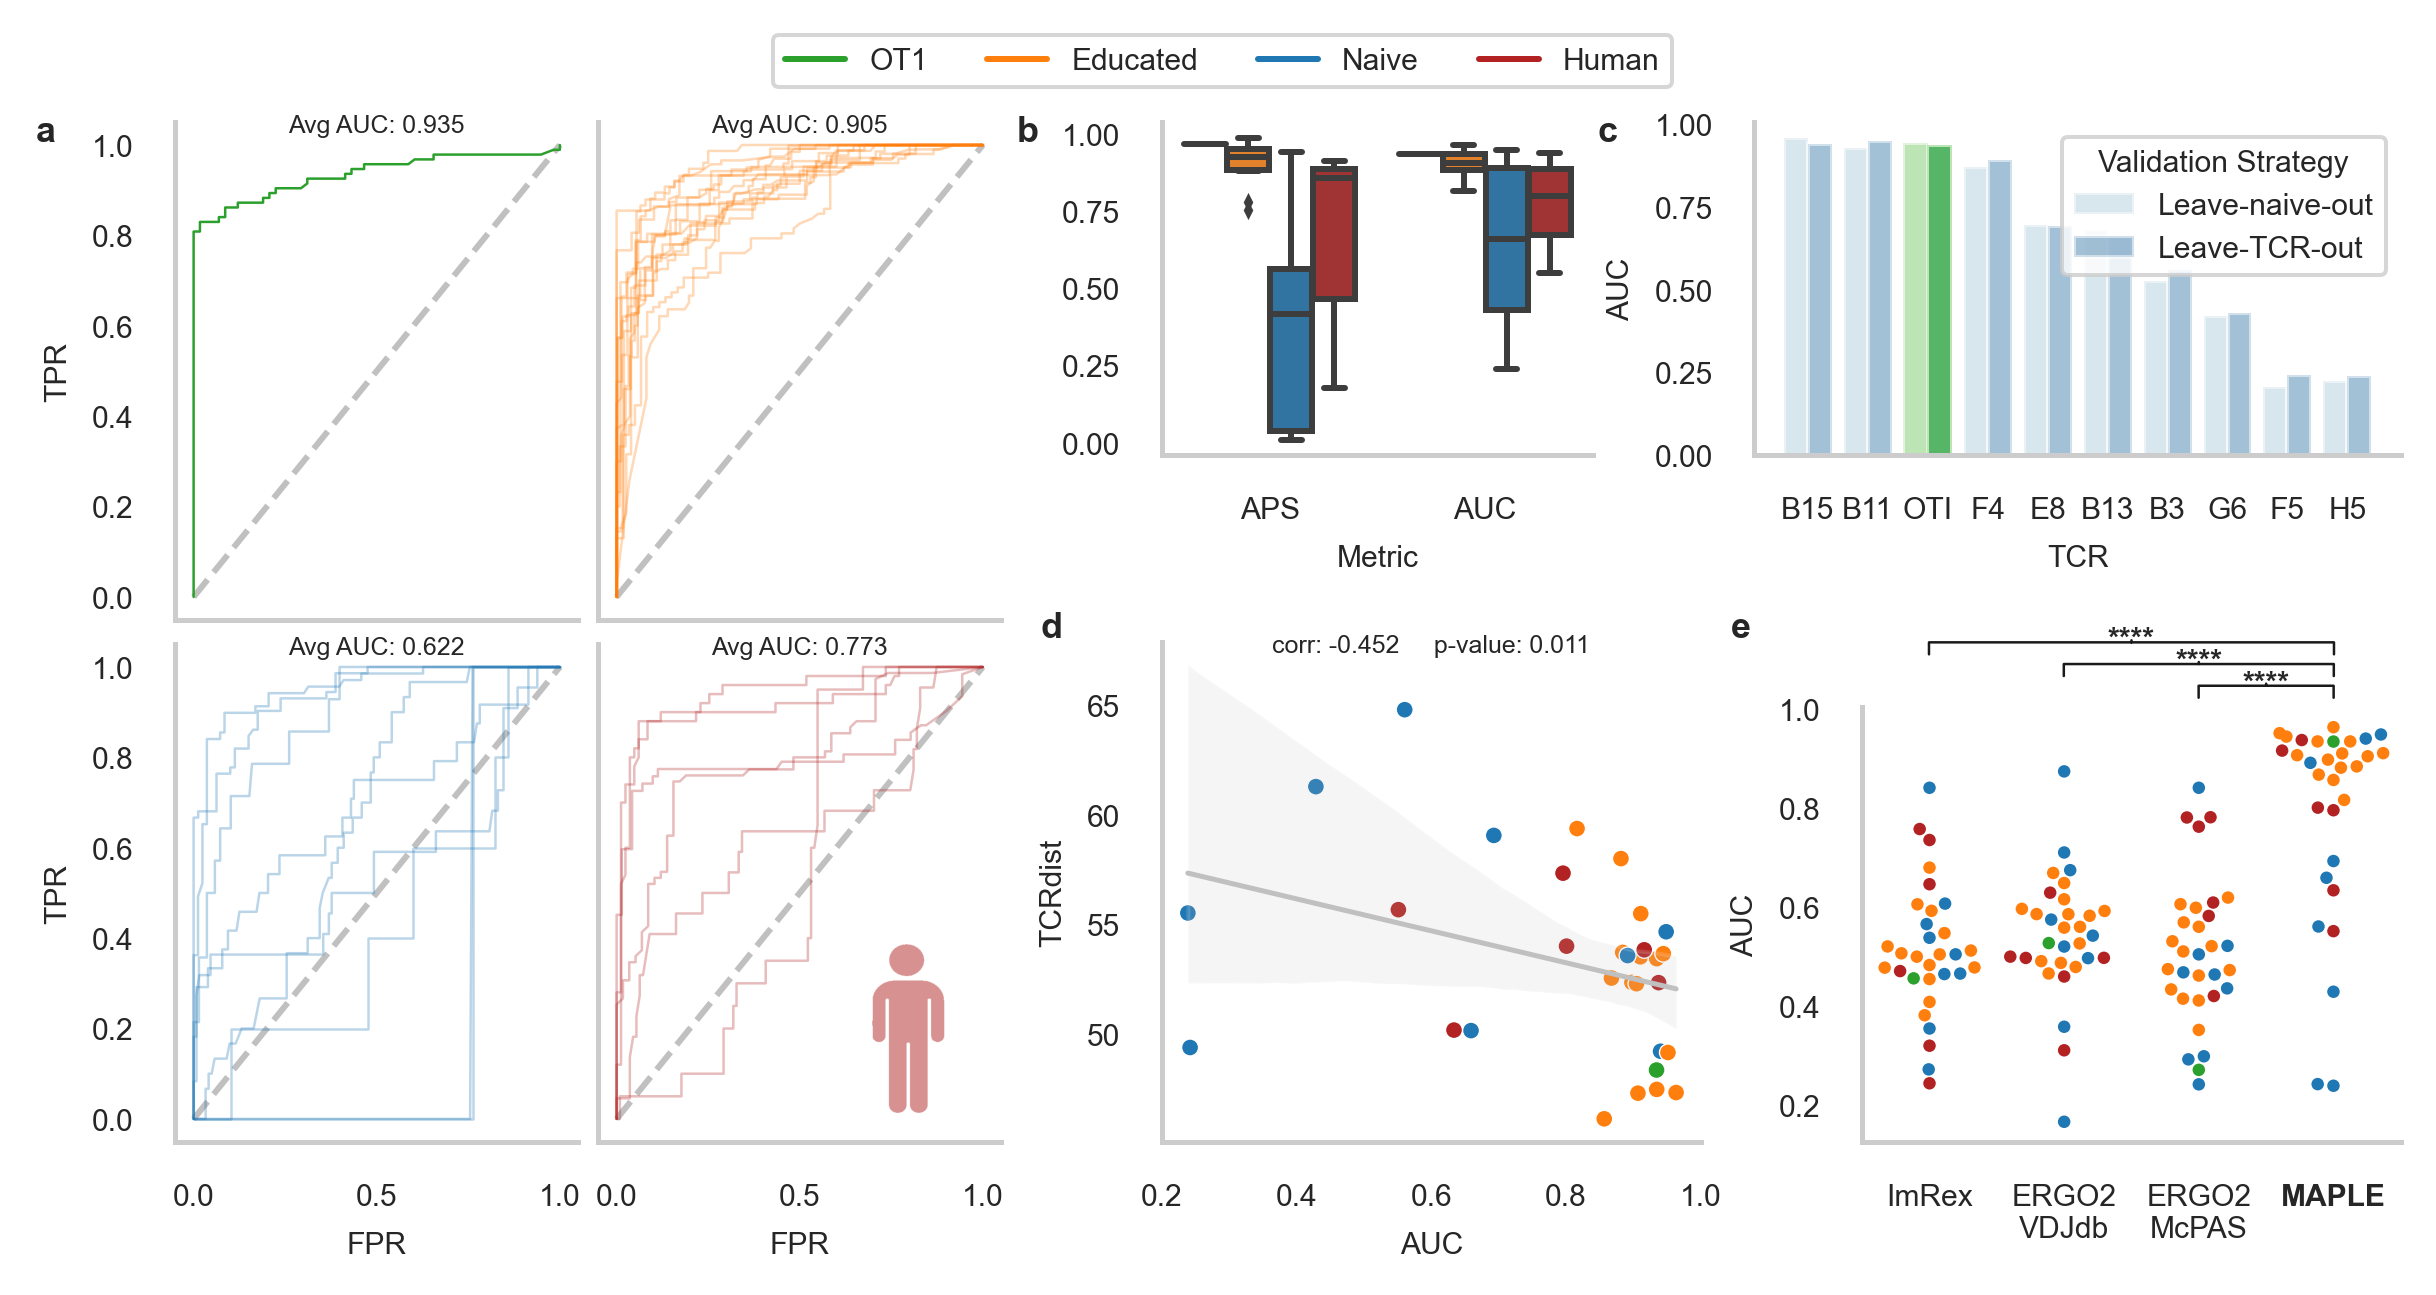

In [27]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH / 2), dpi=DPI)


gridspecs = {}
axes = {}

gridspecs['gs_1234'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[2, 3]
)

gridspecs['gs_1'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1234'][0],
    nrows=2,
    ncols=2,
    height_ratios=[1, 1],
    width_ratios=[1, 1],
    wspace=0.05,
    hspace=0.05
)

gridspecs['gs_234'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1234'][1],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1.5],
    width_ratios=[1],
    hspace=0.45
)

gridspecs['gs_23'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_234'][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 3],
    wspace=0.3
)

gridspecs['gs_34'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_234'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.3
)

gridspecs['gs_4'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_34'][1],
    nrows=2,
    ncols=1,
    height_ratios=[0.15, 1],
    hspace=0
)

for i in range(4):
    axes[f'ax_1_{i}'] = fig.add_subplot(gridspecs['gs_1'][i])
axes['ax_2_tmp'] = fig.add_subplot(gridspecs['gs_23'][0])
axes['ax_2'] = fig.add_subplot(gridspecs['gs_23'][1])
axes['ax_3'] = fig.add_subplot(gridspecs['gs_34'][0])

axes['ax_4_0'] = fig.add_subplot(gridspecs['gs_4'][0])
axes['ax_4_1'] = fig.add_subplot(gridspecs['gs_4'][1])

plot_human(axes['ax_1_3'])

plot_auc(pdf_classification[pdf_classification['Repertoire']=='OTI'], axes['ax_1_0'], ylabel='TPR')
plot_auc(pdf_classification[pdf_classification['Repertoire']=='Educated'], axes['ax_1_1'])
plot_auc(pdf_classification[pdf_classification['Repertoire']=='Naive'], axes['ax_1_2'], ylabel='TPR', xlabel='FPR')
plot_auc(pdf_classification[pdf_classification['Repertoire']=='Human'], axes['ax_1_3'], xlabel='FPR')

plot_naive_test(axes['ax_2'])
plot_metric_boxplot(['APS', 'AUC'], axes['ax_2_tmp'])
tcr_dist_vs_metric(axes['ax_3'], aggr='mean')

plot_baseline_data(performance_baseline, axes['ax_4_1'])
plot_significance(axes['ax_4_0'])

plot_legend(fig)

fig.text(0.01, 0.95, 'a', size='large', weight='bold')
fig.text(0.415, 0.95, 'b', size='large', weight='bold')
fig.text(0.655, 0.95, 'c', size='large', weight='bold')
fig.text(0.425, 0.54, 'd', size='large', weight='bold')
fig.text(0.71, 0.54, 'e', size='large', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_fig4_generalization.pdf', dpi=DPI, bbox_inches='tight')

## Suppl. Other metrics

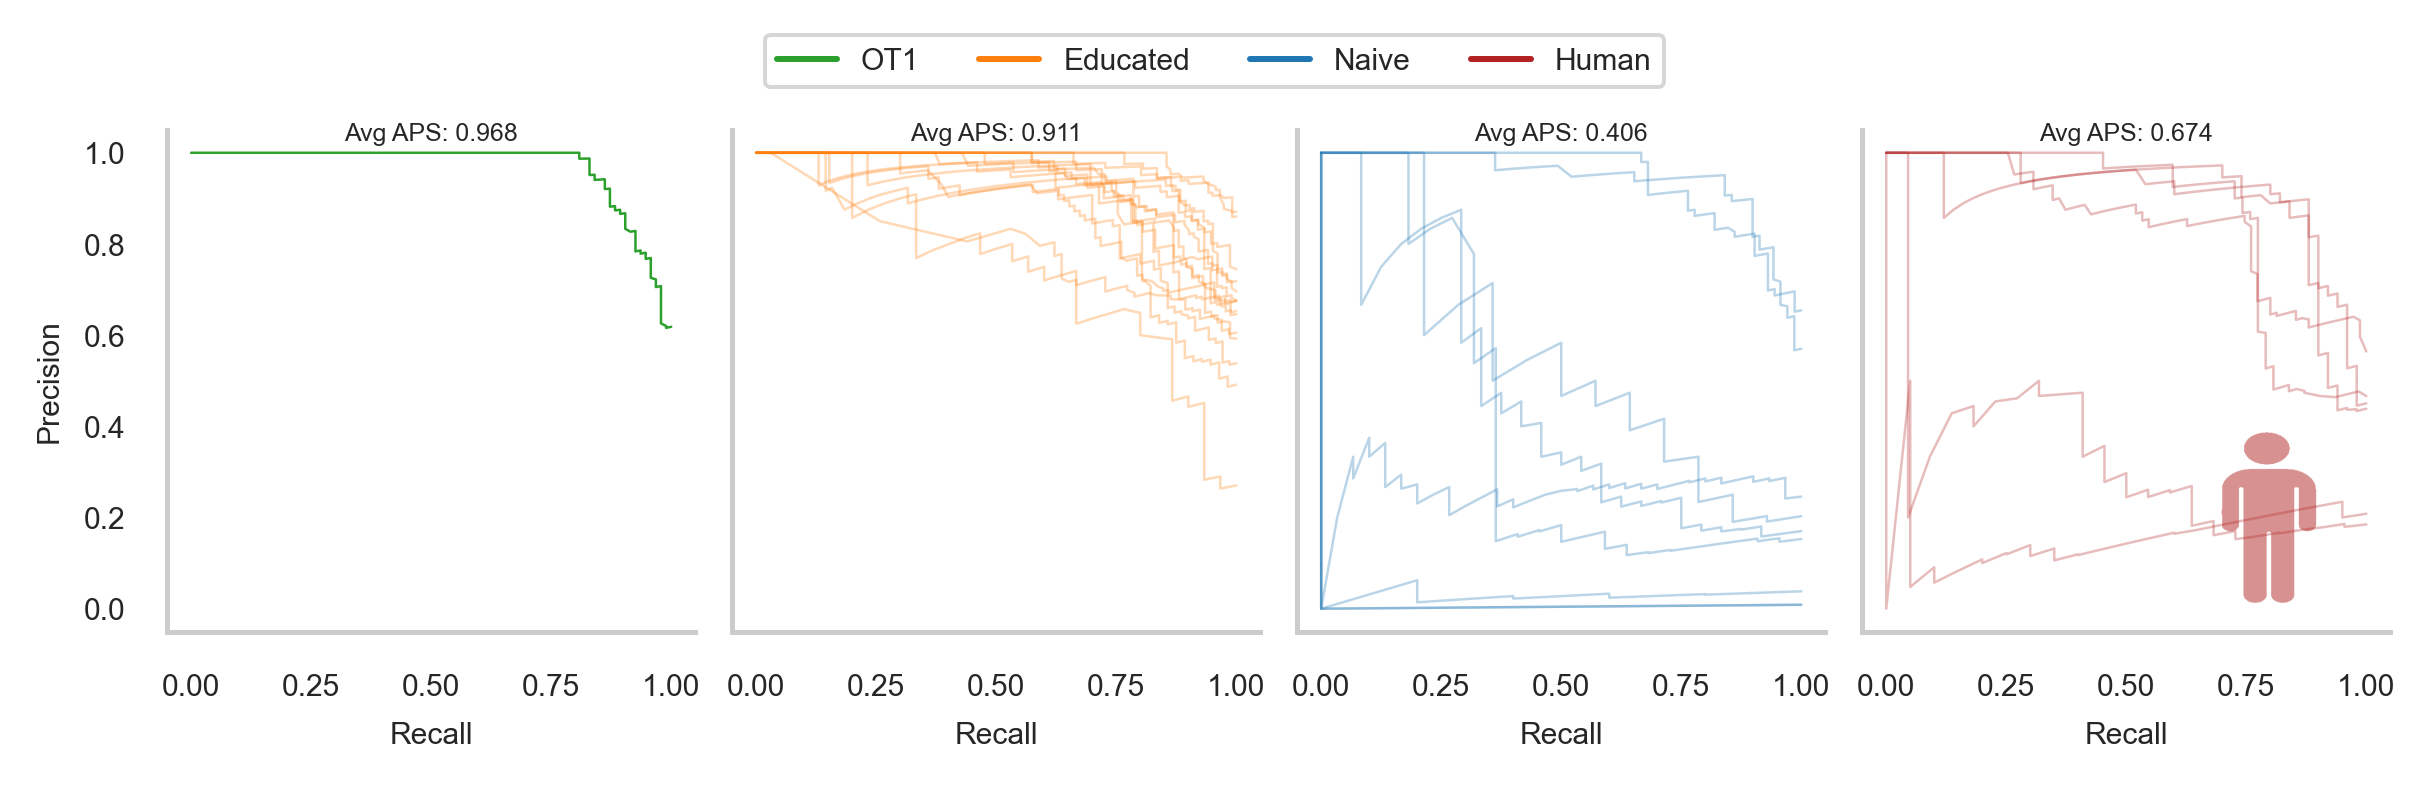

In [28]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH / 3.5), dpi=DPI)


gridspecs = {}
axes = {}

gridspecs['gs_1'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=4,
    width_ratios=[1, 1, 1, 1]
)


for i in range(4):
    axes[f'ax_1_{i}'] = fig.add_subplot(gridspecs['gs_1'][i])

plot_human(axes['ax_1_3'])

plot_auc(pdf_classification[pdf_classification['Repertoire']=='OTI'], axes['ax_1_0'], ylabel='Precision', xlabel='Recall',
         metric_func=metrics.precision_recall_curve,
         metric_name='APS')
plot_auc(pdf_classification[pdf_classification['Repertoire']=='Educated'], axes['ax_1_1'], xlabel='Recall',
         metric_func=metrics.precision_recall_curve,
         metric_name='APS')
plot_auc(pdf_classification[pdf_classification['Repertoire']=='Naive'], axes['ax_1_2'], xlabel='Recall', 
         metric_func=metrics.precision_recall_curve,
         metric_name='APS')
plot_auc(pdf_classification[pdf_classification['Repertoire']=='Human'], axes['ax_1_3'], xlabel='Recall', 
         metric_func=metrics.precision_recall_curve,
         metric_name='APS')

plot_legend(fig, offset=0.05)


fig.tight_layout()
fig.savefig('figures/manuscript_sfig4_generalization.pdf', dpi=DPI, bbox_inches='tight')

## Statistics for the paper

In [29]:
print('\nauc summary\n',
    df_classification_metrics.groupby('Repertoire').describe().T
)

metrics_class_educated = df_classification_metrics[df_classification_metrics['Repertoire']=='Educated']
metrics_class_naive = df_classification_metrics[df_classification_metrics['Repertoire']=='Naive']

print('\nbest edu\n', metrics_class_educated.sort_values('AUC').tail(3))
print('\nworst edu\n', metrics_class_educated.sort_values('AUC').head(3))
print('\nbest naive\n', metrics_class_naive.sort_values('AUC').tail(3))
print('\nworst naive\n', metrics_class_naive.sort_values('AUC').head(3))
print('\nbelow random\n', df_classification_metrics.query('AUC < 0.5').sort_values('AUC'))

print('\ncomparing auc of leave-tcr-out and leave-naive-out\n', stats.ttest_rel(*pd.merge(
     naive_test_data,
     df_classification_metrics,
     left_on='tcr', right_on='tcr',
)[['AUC_x', 'AUC_y']].values.T))


auc summary
 Repertoire    Educated      Human      Naive        OTI
index count  15.000000   6.000000   9.000000   1.000000
      mean   12.000000  27.500000  10.666667  24.000000
      std     4.472136   1.870829  10.368221        NaN
      min     5.000000  25.000000   0.000000  24.000000
      25%     8.500000  26.250000   2.000000  24.000000
      50%    12.000000  27.500000   4.000000  24.000000
      75%    15.500000  28.750000  21.000000  24.000000
      max    19.000000  30.000000  23.000000  24.000000
AUC   count  15.000000   6.000000   9.000000   1.000000
      mean    0.904505   0.772530   0.622447   0.934519
      std     0.039265   0.153326   0.278455        NaN
      min     0.816486   0.551106   0.238411   0.934519
      25%     0.883011   0.674184   0.428571   0.934519
      50%     0.906950   0.798259   0.659016   0.934519
      75%     0.934815   0.887420   0.891563   0.934519
      max     0.963614   0.937590   0.948839   0.934519
APS   count  15.000000   6.000000 

In [30]:
print('Paired t-test between MAPLE and baseline models on AUC:')
for col in ['ergo-mcpas', 'ergo-vdjdb', 'imrex']:
    res = stats.ttest_rel(performance_baseline[col], performance_baseline['MAPLE'])
    print(f'{col}: {res}')
    
print('\nPaired t-test between MAPLE and baseline models on Spearman:')
for col in ['ergo-mcpas', 'ergo-vdjdb', 'imrex']:
    res = stats.ttest_rel(performance_baseline_regression[col], performance_baseline_regression['MAPLE'])
    print(f'{col}: {res}')

Paired t-test between MAPLE and baseline models on AUC:
ergo-mcpas: Ttest_relResult(statistic=-6.714094080563567, pvalue=1.9316965637481774e-07)
ergo-vdjdb: Ttest_relResult(statistic=-6.172011007187245, pvalue=8.629125653356991e-07)
imrex: Ttest_relResult(statistic=-6.091674654709063, pvalue=1.0793929771092463e-06)

Paired t-test between MAPLE and baseline models on Spearman:
ergo-mcpas: Ttest_relResult(statistic=-12.493544497248283, pvalue=2.0248025942443642e-13)
ergo-vdjdb: Ttest_relResult(statistic=-13.759636415834866, pvalue=1.6982204765441952e-14)
imrex: Ttest_relResult(statistic=-12.767533309308085, pvalue=1.1670876000983884e-13)
